# Working with `zea.Pipeline`
In this notebook, we will explore how to use the [``zea.Pipeline``](../pipeline.rst) class to create a pipeline for processing data.

Optionally: First we will set the Keras backend to JAX (can be any of the backends supported by Keras), and set internal zea caching to False, to always run from scratch.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/pipeline/zea_pipeline_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/pipeline/zea_pipeline_example.ipynb)
&nbsp;
[![Hugging Face dataset](https://img.shields.io/badge/Hugging%20Face-Dataset-yellow?logo=huggingface)](https://huggingface.co/datasets/zeahub/picmus)

In [1]:
%%capture
%pip install zea

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["ZEA_DISABLE_CACHE"] = "1"

We'll import all necessary libraries and modules, including the `zea.Pipeline` class, and all necessary `zea.ops` for our pipeline.

In [3]:
import matplotlib.pyplot as plt

from zea import init_device
from zea.data import load_file
from zea.display import to_8bit
from zea.ops import (
    Pipeline,
    PatchedGrid,
    EnvelopeDetect,
    Normalize,
    LogCompress,
    TOFCorrection,
    DelayAndSum,
)
from zea.visualize import set_mpl_style

zea: Using backend 'jax'


E0000 00:00:1751985771.944573 1442493 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751985771.954149 1442493 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751985771.977579 1442493 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751985771.977614 1442493 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751985771.977616 1442493 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751985771.977618 1442493 computation_placer.cc:177] computation placer already registered. Please check linka

We will work with the GPU if available, and initialize using `init_device` to pick the best available device. Also, (optionally), we will set the matplotlib style for plotting.

In [4]:
init_device(verbose=False)
set_mpl_style()

Since we'll be plotting the resulting image quite a few time, let's make helper function for displaying the B-mode.

In [5]:
def plot_data(data, dynamic_range, scan):
    """Helper function to plot the data."""
    image = to_8bit(data, dynamic_range=dynamic_range)
    plt.figure()
    # Convert xlims and zlims from meters to millimeters for display
    xlims_mm = [v * 1e3 for v in scan.xlims]
    zlims_mm = [v * 1e3 for v in scan.zlims]
    plt.imshow(image, cmap="gray", extent=[xlims_mm[0], xlims_mm[1], zlims_mm[1], zlims_mm[0]])
    plt.xlabel("X (mm)")
    plt.ylabel("Z (mm)")

## Loading data
To start, we will load some data from the [PICMUS](https://www.creatis.insa-lyon.fr/Challenge/IEEE_IUS_2016/home) dataset, which we converted to zea format and is stored for convenience on the [Hugging Face Hub](https://huggingface.co/zeahub). You could also easily load your own data in zea format, using a local path instead of the HF URL.

For more ways and information to load data, please see the [Data documentation](../../data-acquisition.rst) or the data loading example notebook [here](../data/zea_data_example.ipynb).

Note that all acquisition parameters are also stored in the zea data format, such that when we load the data we can also construct `zea.Probe` and `zea.Scan` objects, that will be usefull later on in the pipeline.

In [6]:
path = "hf://zeahub/picmus/database/experiments/contrast_speckle/contrast_speckle_expe_dataset_iq/contrast_speckle_expe_dataset_iq.hdf5"

data, scan, probe = load_file(
    path=path,
    indices=[0],
    data_type="raw_data",
)

# index the first frame
data_frame = data[0]

scan.n_ch = 2  # IQ data, should be stored in file but isn't currently
scan.xlims = probe.xlims
scan.zlims = (0, 0.06)  # reduce z-limits a bit for better visualization
dynamic_range = (-50, 0)  # set dynamic range for display

contrast_speckle_expe_dataset_iq.hdf5:   0%|          | 0.00/64.0M [00:00<?, ?B/s]

First, we will use a default pipeline to process the data, and reconstruct the B-mode image from raw data. Note that the data as well as the parameters are passed along together as a dictionary to the pipeline. By default, the data will be assumed to be stored in the `data` key of the dictionary. Parameters are stored under their own name. This can all be customized, but for now we will use the defaults.

Note that we first need to prepare all parameters using `pipeline.prepare_parameters()`. This will create the flattened dictionary of tensors (converted to the backend of choice). You don't need this step if you already have created a dictionary of tensors with parameters manually yourself. However, since we currently have the parameters in a `zea.Probe` and `zea.Scan` object, we have to use the `pipeline.prepare_parameters()` method to extract them.

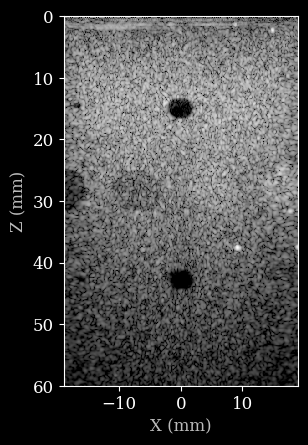

In [7]:
pipeline = Pipeline.from_default(
    num_patches=100,
    baseband=True,
    pfield=False,
    with_batch_dim=False,
    jit_options="pipeline",
)

parameters = pipeline.prepare_parameters(probe, scan)
parameters.pop("dynamic_range", None) # remove dynamic_range since we will set it manually later

inputs = {pipeline.key: data_frame}

# dynamic parameters can be freely passed here as keyword arguments
outputs = pipeline(**inputs, **parameters)

image = outputs[pipeline.output_key]

plot_data(image, dynamic_range, scan)

Now let's construct a custom pipeline to process the data. We will use the `zea.Pipeline` class and pass a list of operations to it. The operations will be executed in the order they are provided, and the output of each operation will be passed as input to the next operation as a dictionary. You can specify the input and output key for each operation, which for will be assumed to be `data` by default. This also allows you to create complex branched pipelines, but we will keep it simple for now. Note that pipelines can also be nested, which we will do for the beamforming stage. This allows us to use the `zea.ops.PatchedGrid` pipeline to wrap the beamforming operations, resulting in a more memory efficient pipeline.

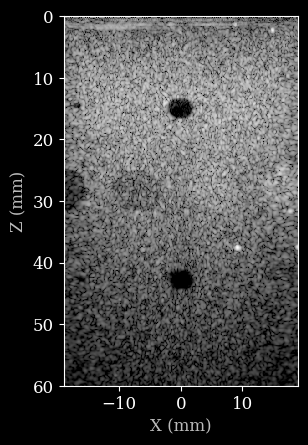

In [8]:
pipeline = Pipeline(
    operations=[
        PatchedGrid(operations=[TOFCorrection(), DelayAndSum()], num_patches=100),
        EnvelopeDetect(),
        Normalize(),
        LogCompress(),
    ],
    with_batch_dim=False,
    jit_options="pipeline",
)

outputs = pipeline(**inputs, **parameters, dynamic_range=(-50, 0))

image = outputs[pipeline.output_key]

plot_data(image, dynamic_range, scan)

Let's say we want to change a parameter with an existing pipeline. Since the pipeline is stateless, we can simply pass all the existing parameters, as well as the updated parameter, to the pipeline. This should also be fast, since the pipeline is already ([JIT](https://docs.jax.dev/en/latest/jit-compilation.html)) compiled.

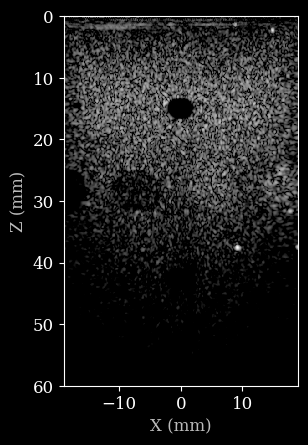

In [9]:
dynamic_range = (-30, 0)

outputs = pipeline(**inputs, **parameters, dynamic_range=dynamic_range)

image = outputs[pipeline.output_key]

plot_data(image, dynamic_range, scan)

We can also do a bit more complex stuff. Let's see how to change the number of transmits for reconstruction. We can set the number of transmits in the `zea.Scan` class, which will automatically also update internal parameters of the scan. Then we have to prepare the parameters again to convert them to a dictionary of tensors. Finally, we can pass the updated parameters to the pipeline and run it again.

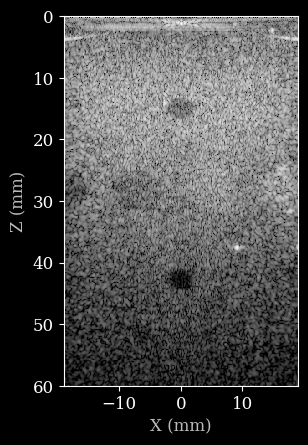

In [10]:
dynamic_range = (-50, 0)
scan.set_transmits(3)
parameters = pipeline.prepare_parameters(probe, scan)

data_11_transmits = data[0][scan.selected_transmits]

inputs = {pipeline.key: data_11_transmits}

outputs = pipeline(**inputs, **parameters)

image = outputs[pipeline.output_key]

plot_data(image, dynamic_range, scan)